In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [7]:
from typing import TypedDict, Annotated
from operator import add

class State(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, add]
    best_selected_joke: str
    
class JokeState(TypedDict):
    subject: str

In [4]:
from pydantic import BaseModel

class Subject(BaseModel):
    subjects: list[str]

In [ ]:
prompt_template = """Generate a comma separated list between 2 and 5 examples related to {topic}"""

def generate_subjects(state: State) -> State:
    prompt = prompt_template.format(topic=state["topic"])
    response = llm.with_structured_output(Subject).invoke(prompt)
    
    print("Response :: ", response)
    return {"subjects": response.subjects}


In [6]:
generate_subjects({"topic": "Animal"})

Response ::  subjects=['Lion', 'Elephant', 'Dolphin', 'Penguin', 'Kangaroo']


{'subjects': ['Lion', 'Elephant', 'Dolphin', 'Penguin', 'Kangaroo']}

In [9]:
import threading

def generate_joke(state: JokeState) -> State:
    thread_name = threading.current_thread().name
    print(f"Thread Name: {thread_name}... Inside generate_joke")
    
    prompt = """Generate a Joke about {subject}""".format(subject=state["subject"])
    response = llm.invoke(prompt)
    
    return {"jokes": [response.content]}

In [10]:
subjects = ['Lion', 'Elephant', 'Dolphin', 'Penguin', 'Kangaroo']
for subject in subjects:
    print(generate_joke({"subject": subject}))

Thread Name: MainThread... Inside generate_joke
{'jokes': ['Why did the lion eat the tightrope walker?\n\nBecause he wanted a well-balanced meal!']}
Thread Name: MainThread... Inside generate_joke
{'jokes': ['Why did the elephant bring a suitcase to the party?\n\nBecause it wanted to pack its trunk! 🐘🎉']}
Thread Name: MainThread... Inside generate_joke
{'jokes': ['Why did the dolphin bring a towel to the party?\n\nBecause he wanted to make a splash on the dance floor!']}
Thread Name: MainThread... Inside generate_joke
{'jokes': ['Why don’t penguins like talking to strangers at parties?\n\nBecause they find it hard to break the ice! ']}
Thread Name: MainThread... Inside generate_joke
{'jokes': ['Why did the kangaroo get kicked out of the party?\n\nBecause he kept hopping around and stealing the spotlight!']}


In [22]:
def best_joke(state: State) -> State:
    thread_name = threading.current_thread().name
    print(f"Thread Name: {thread_name}... Inside best_joke")
    
    template = """Below are a bunch of jokes about {topic}.
                Select the best one 
                Jokes: {jokes}
            """
    prompt = template.format(topic=state["topic"], jokes=state["jokes"])
    response = llm.invoke(prompt)
    
    return {"best_selected_joke": response.content}

In [12]:
jokes = ["Why did the lion eat the tightrope walker?\n\nBecause he wanted a well-balanced meal!",
         "Why did the elephant bring a suitcase to the party?\n\nBecause it wanted to pack its trunk! 🐘🎉",
         "Why did the dolphin bring a towel to the party?\n\nBecause he wanted to make a splash on the dance floor!",
         "Why don’t penguins like talking to strangers at parties?\n\nBecause they find it hard to break the ice!",
         "Why did the kangaroo get kicked out of the party?\n\nBecause he kept hopping around and stealing the spotlight!"]

print(best_joke({"topic": "Animal", "jokes": jokes}))

Thread Name: MainThread... Inside best_joke
{'best_selected_joke': "The best joke is subjective, but one of the standout options is:\n\n**'Why don’t penguins like talking to strangers at parties?\\n\\nBecause they find it hard to break the ice!'**\n\nThis joke is clever and has a nice pun. Let's assign it an ID of 3 for selection. \n\nSo, the ID of the best one is **3**."}


In [14]:
from langgraph.types import Send

def continue_to_jokes(state: State):
    sends = [Send("generate_joke", {"subject": subject}) for subject in subjects]
    return sends


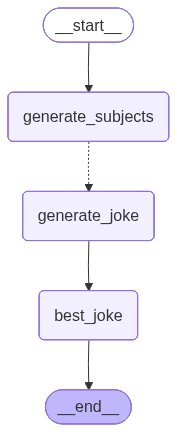

In [23]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image

flow = StateGraph(state_schema=State)

flow.add_node("generate_subjects", generate_subjects)
flow.add_node("generate_joke", generate_joke)
flow.add_node("best_joke", best_joke)

flow.add_edge(START, "generate_subjects")
flow.add_conditional_edges("generate_subjects", continue_to_jokes, ["generate_joke"])
flow.add_edge("generate_joke", "best_joke")
flow.add_edge("best_joke", END)

graph = flow.compile()
Image(graph.get_graph().draw_mermaid_png())

In [24]:
response = graph.invoke({"topic": "Animals"})
print(response)

Response ::  subjects=['Lions', 'Elephants', 'Dolphins', 'Giraffes', 'Polar Bears']
Thread Name: ThreadPoolExecutor-1_0... Inside generate_joke
Thread Name: ThreadPoolExecutor-1_1... Inside generate_joke
Thread Name: ThreadPoolExecutor-1_2... Inside generate_joke
Thread Name: ThreadPoolExecutor-1_3... Inside generate_joke
Thread Name: ThreadPoolExecutor-1_4... Inside generate_joke
Thread Name: MainThread... Inside best_joke
{'topic': 'Animals', 'subjects': ['Lions', 'Elephants', 'Dolphins', 'Giraffes', 'Polar Bears'], 'jokes': ['Why don’t lions ever use smartphones?\n\nBecause they always get caught in the “roar” of the moment! 🦁📱', "Why do elephants never use computers?\n\nBecause they're afraid of the mouse! 🐘🐭", 'Why did the dolphin bring a towel to the party? \n\nBecause he wanted to make a splash!', "Why don't penguins like talking to strangers at parties?\n\nBecause they find it hard to break the ice! 🐧😄", 'Why don’t kangaroos make good secret agents?\n\nBecause they always jump 